# Deep Learning on Inner speech

In [ ]:
#@title Install dependencies 
!git clone https://github.com/N-Nieto/Inner_Speech_Dataset -q
!pip3 install mne -q
!pip install umap-learn

!pip3 install pyriemann
from sklearn.cluster import KMeans
from pyriemann.estimation import Covariances
from pyriemann.utils.base import invsqrtm
!pip3 install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 29.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=a501cbedd075f41910d1285446835a067429eb2252b1835a12dc919dab89e805
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=75c9ef1e62c5951df7a16bbda22a8ed0fd83eb29b282db54d8491b1ddb0a7d31
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent
Looking

In [ ]:
#@title Imports 
import os
import mne 
import time
import copy
import pickle
import random
import torch
import warnings
import torchvision
import gc
import collections
import umap


import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from google.colab import drive, files
from tqdm.notebook import tqdm, trange
from torch.utils.data import random_split
from torchvision import datasets, transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject, Extract_block_data_from_subject, Extract_data_multisubject
from Inner_Speech_Dataset.Python_Processing.Data_processing import *

np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 

In [ ]:
#@title Set random seed
# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)
SEED = 23
set_seed(seed=SEED)

Random seed 23 has been set.


In [ ]:
# @title Set device (GPU or CPU).

# inform the user if the notebook uses GPU or CPU.
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("No GPU enabled in this notebook.")
  else:
    print("GPU is enabled in this notebook.")

  return device


DEVICE = set_device()

GPU is enabled in this notebook.


# Data Loading

In [ ]:
# @title Create directory if not exists {form-width:"25%"}

def ensure_dir(dir_name):
  import os
  if not os.path.exists(dir_name):
      os.makedirs(dir_name)

In [ ]:
# @title Mount drive {form-width:"25%"}
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Implementación de métodos

In [ ]:
#@title extract_data_ms { form-width: "25%" }

def Extract_data_multisubject_label(root_dir, N_S_list, datatype='EEG'):
    """
    Load all blocks for a list of subject and stack the results in X

    Args:
        root_dir (string): root directory from where the files will be 
        N_S_list (list[integer], optional): list of subjects
        datatype (string, optional): type of experiment data (EEG, EXG, baseline)

    Returns:
        X (numpy array): Raw data for the subjects specified in N_S_list
        parameter
        Y (numpy array): Its labels (which command the subject is evoking)
    """

    print("Extract_data_multisubject_label running")

    N_B_arr = [1, 2, 3]
    tmp_list_X = []
    tmp_list_Y = []
    rows = []
    total_elem = len(N_S_list)*3  # assume 3 sessions per subject
    S = 0
    for N_S in N_S_list:
        print("Iteration ", S)
        print("Subject ", N_S)
        for N_B in N_B_arr:

            # name correction if N_Subj is less than 10
            if N_S < 10:
                Num_s = 'sub-0'+str(N_S)
            else:
                Num_s = 'sub-'+str(N_S)

            base_file_name = root_dir + '/derivatives/' + Num_s + \
                '/ses-0' + str(N_B) + '/' + Num_s+'_ses-0'+str(N_B)
            events_file_name = base_file_name+'_events.dat'

            if datatype == "EEG" or datatype == "eeg":
                #  load data and events
                eeg_file_name = base_file_name+'_eeg-epo.fif'
                print("Inner iteration ", N_B)
                data_tmp_X = mne.read_epochs(
                    eeg_file_name, verbose='WARNING')._data
                rows.append(data_tmp_X.shape[0])
                if S == 0 and N_B == 1:  # assume same number of channels, time steps, and column labels in every subject and session
                    print("saving channels and steps")
                    chann = data_tmp_X.shape[1]
                    steps = data_tmp_X.shape[2]
                    # columns=data_tmp_Y.shape[1]
                tmp_list_X.append(data_tmp_X)
                tmp_list_Y.append(np.ones(data_tmp_X.shape[0])*S)

            # ToDo improvement not applied to exg and baseline datatypes yet
            elif datatype == "EXG" or datatype == "exg":
                file_name = root_dir + '/derivatives/' + Num_s + '/ses-0' + \
                    str(N_B) + '/' + Num_s+'_ses-0'+str(N_B)+'_exg-epo.fif'
                X = mne.read_epochs(file_name, verbose='WARNING')
                data[N_B] = X._data

            elif datatype == "Baseline" or datatype == "baseline":
                file_name = root_dir + '/derivatives/' + Num_s + '/ses-0' + \
                    str(N_B) + '/' + Num_s+'_ses-0' + \
                    str(N_B)+'_baseline-epo.fif'
                X = mne.read_epochs(file_name, verbose='WARNING')
                data[N_B] = X._data

            else:
                print("Invalid Datatype")
        S += 1

    X = np.empty((sum(rows), chann, steps))
    Y = np.empty((sum(rows)), dtype=np.int8)
    offset = 0
    # put elements of list into numpy array
    for i in range(total_elem):
        print("Saving element into array: ", i)
        X[offset:offset+rows[i], :, :] = tmp_list_X[0]
        Y[offset:offset+rows[i]] = tmp_list_Y[0]
        offset += rows[i]
        del tmp_list_X[0]
        del tmp_list_Y[0]
        gc.collect()
    print("X shape", X.shape)
    print("Y shape", Y.shape)
    return X, Y


def extract_data_ms(root_dir, datatype, subjects=None, real_task=True):
    """
    Makes the list of subjects that will be read from disk, leaving out
    any subject if necessary

    Args:
        root_dir (string): root directory from where the files will be read
        datatype (string): type of experiment data (EEG, EXG, baseline)
        real_task (bool, optional): train with real task or a dummy task
        (for a pre-train with another task). Defaults to True.
        subjects (list[integer], optional): for pre-train, it will default 
        to None, meaning that all the subjects will be used (except for the one
        under test). For fine-tuning, it will only be a single subject, which
        is converted to a list

    Returns:
        X_raw (numpy array): Raw data for the subjects specified in subject
        parameter
        Y (numpy array): Its labels (which command the subject is evoking)
    """

    print("extract_data_ms running")

    if (subjects == None):
        L = [i+1 for i in range(10)]
        # a subject is kept away for fine tuning
        L.pop(sub-1)

        # # delete "bad" subjects from pre training
        # leaving this out because it is hard to e
        # L.pop(2-1)
        # L.pop(4-1-1)
        # L.pop(8-1-1-1)
    else:
        L = [subjects]
    print(L)

    # real task
    if(real_task):
        X_raw, Y = Extract_data_multisubject(root_dir, L, datatype=datatype)
    else:
        # dummy task
        X_raw, Y = Extract_data_multisubject_label(
            root_dir, L, datatype=datatype)

    print("\n \n")
    print(X_raw.shape)
    print(Y.shape)
    print(Y.dtype)

    return X_raw, Y


In [ ]:
# @title select_time_window {form-width: "25%"}
def cut_useful_time(X_raw, t_start=1.5, t_end=3.5, fs=256, float_point=None):
    """
    Method that crops the third dimension of the tensor to select the time in
    which the activity takes place
    
    Args:
        X_raw (numpy array): Raw data that was read from disk. These are the trials
        t_start (float, optional): Start time of interest in seconds. Defaults to 1.5.
        t_end (float, optional): End time of interest in seconds. Defaults to 3.5.
        fs (int, optional): Sampling rate in hz. Defaults to 256.
        float_point (int, optional): Bits used to represent floats. Defaults to None = 64bits.

    Returns:
        X (numpy array): Data with less items in third dimension (data that is not of interest
        is left out)
    """

    print("cut_useful_time running")
    # Cut useful time
    import gc
    X = Select_time_window(X=X_raw, t_start=t_start, t_end=t_end, fs=fs)
    print(X.shape)
    del X_raw
    gc.collect()

    X = cast_float_point(X, float_point)

    return X


def cast_float_point(X, float_point=None):
    """
    Converts provided array to float type

    Args:
        X (numpy array): Array that will be casted
        float_point (integer, optional): how many bits will be used. Defaults to None = 64bits.

    Returns:
        X (numpy array): casted array
    """

    if float_point == 32:
        X = np.float32(X)
    elif float_point == 16:
        X = np.float16(X)

    return X


In [ ]:
# @title data_processing {form-width: "25%"}
def transform_for_classificator(X, Y, Classes, Conditions, real_task=True):
    """
    Wrapper method that acts based on training with real or dummy task and calls
    the actual method that filters data.

    Args:
        X (numpy array): Raw data that was read from disk. These are the trials
        Y (numpy array): Labels (the command that the subject is evoking)
        Classes (string): Classes of interest (ARRIBA, ABAJO, IZQUIERDA, DERECHA)
        Conditions (string): Conditions under test (inner, visualized, pronounced).
        real_task (int, optional): Whether we are training with real or dummy task.
        Labels will be modified accoridingly in this last case

    Returns:
        X (numpy array): Data with (possibly) less items in first dimension (data that is not of interest
        is left out)
    """

    print("transform_for_classificator running")
    if(real_task):
        # for pre train with real task
        X, Y = Transform_for_classificator(X, Y, Classes, Conditions)
    else:
        # for pre train with dummy task
        X, Y = Transform_for_classificator_label(X, Y, Classes, Conditions)

    return X, Y


def split_data(X, Y, test_size, val_size, scl, SEED, window_len, window_step, fs=256, pre_train=False):
    """
    Method that takes the data and split it in smaller parts, in the time dimension.
    In this way, we end up with more trials to train the model. It can be seen
    as a data augmentation technique.
    It also makes the classical train-test-validation kind of split.

    Args:
        X (numpy array): Raw data that was read from disk. These are the trials
        Y (numpy array): Labels (the command that the subject is evoking)
        test_size (float): Percentage of trials that will be used for testing purposes
        (as a fraction of the total).
        val_size (float): Percentage of trials that will be used for validation
        (as a fraction of the total).
        scl (MinMaxScaler): https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
        SEED (int): Random seed to obtain reproducible output across multiple splits.
        window_len(float): Used for splitting the trials in time dimension, specify how long
        the mini-trial will be, in seconds
        window_step(float): How much the window will move in seconds after each cut, used to introduce
        overlapping if desired
        fs (int, optional): sampling frequency, in hz. Defaults to 256
        pre_train(bool, optional): Parameter that tells if pre-training phase
        is being executed (meaning we only need training and validation ~),
        or fine-tuning instead (in this case, we need train, test and validation
        ~).

    Returns:
        X_train (numpy array): Training partition of data
        X_val (numpy array): Validation partition of data
        X_test (numpy array): Testing partition of data
        Y_train (numpy array): Training partition of labels
        Y_val (numpy array): Validation partition of labels
        Y_test (numpy array): Testing partition of labels
        len_window_sample(int): How many time steps are in each trial. As it will be
        used in test phase, it has meaningful data in finetuning phase
    """

    print("split_data running")
    if(pre_train):
        X_train, X_val, Y_train, Y_val = train_test_split(
            X, Y, test_size=val_size, random_state=SEED, stratify=Y)
        # Split Trial
        del X, Y
        import gc
        gc.collect()
        X_train, Y_train = Split_trial_in_time(
            X_train, Y_train, window_len, window_step, fs)
        X_val, Y_val = Split_trial_in_time(
            X_val, Y_val, window_len, window_step, fs)
        X_test = None
        Y_test = None
        len_window_sample = None
    else:
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=SEED, stratify=Y)
        X_train, X_val, Y_train, Y_val = train_test_split(
            X_train, Y_train, test_size=val_size, random_state=SEED, stratify=Y_train)
        X_in_shape = X_train.shape[0]

        X_train, Y_train = Split_trial_in_time(
            X_train, Y_train, window_len, window_step, fs)
        X_val, Y_val = Split_trial_in_time(
            X_val, Y_val, window_len, window_step, fs)
        X_test, Y_test = Split_trial_in_time(
            X_test, Y_test, window_len, window_step, fs)
        X_out_shape = X_train.shape[0]
        len_window_sample = int(X_out_shape/X_in_shape)

    # Scale to [0,1] each channel
    for chn in range(X_train.shape[1]):
        X_train[:, chn, :] = scl.fit_transform(X_train[:, chn, :])

        X_val[:, chn, :] = scl.transform(X_val[:, chn, :])
        if(not pre_train):
            X_test[:, chn, :] = scl.transform(X_test[:, chn, :])

    # print("Final data shape")
    # print("X_train.shape", X_train.shape)
    # print("X_val.shape", X_val.shape)
    # print("X_test.shape", X_test.shape)

    # print("Data atributes")
    # print("Min:" + str(X_train.min()))
    # print("Max:" + str(X_train.max()))
    # print("Data Type:" + str(X_train.dtype))

    # print("saving Y files in pretraining")
    # with open('/gdrive/My Drive/DataSet/luchi/Ytr.npy', 'wb+') as f:
    #   print(f"about to save Ytr, size {Y_train.shape}")
    #   np.save(f, Y_train)
    # with open('/gdrive/My Drive/DataSet/luchi/Yval.npy', 'wb+') as f:
    #   print(f"about to save Ytr, size {Y_val.shape}")
    #   np.save(f, Y_val)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test, len_window_sample


In [ ]:
# @title euclidean_aligment {form-width:"25%"}



def EU(Xtr, Xval, Xte=None):
    """
    Euclidean Aligment

    Args:
        Xtr (numpy array): Training partition
        Xval (numpy array): Validation partition
        Xte (numpy array, optional): Testing partition. Defaults to None in pre-training phase (no testing is done there).

    Returns:
        Xtr_eu (numpy array): Aligned training partition
        Xval_eu (numpy array): Aligned validation partition
        Xte_eu (numpy array): Aligned testing validation partition
    """

    print("euclidean alignment running")
    # Estimate single trial covariance
    cov_tr = Covariances().transform(Xtr)
    # cov_tr_fine= Covariances().transform(Xtr_fine)

    Ctr = cov_tr.mean(0)
    # Ctr_fine = cov_tr_fine.mean(0)

    # aligment
    Xtr_eu = np.asarray([np.dot(invsqrtm(Ctr), epoch) for epoch in Xtr])
    Xval_eu = np.asarray([np.dot(invsqrtm(Ctr), epoch) for epoch in Xval])
    if (Xte is not None):
        Xte_eu = np.asarray([np.dot(invsqrtm(Ctr), epoch) for epoch in Xte])
    else:
        Xte_eu = None
        # print("saving EU files in pretraining")
        # with open('/gdrive/My Drive/DataSet/luchi/Xtr.npy', 'wb+') as f:
        #   print(f"about to save Xtr eu, size {Xtr_eu.shape}")
        #   np.save(f, Xtr_eu)
        # with open('/gdrive/My Drive/DataSet/luchi/Xval.npy', 'wb+') as f:
        #   print(f"about to save Xtr eu, size {Xval_eu.shape}")
        #   np.save(f, Xval_eu)

    return Xtr_eu, Xval_eu, Xte_eu


In [ ]:
# @title cast_to_dataset {form-width:"25%"}

def convert_to_dataset(X_numpy, Y_numpy, DEVICE):
  """
  Converts numpy array into torch TensorDataset

  Args:
      X_numpy (numpy array): Array of samples
      Y_numpy (numpy array): Array of labels
      DEVICE (string): either CPU or GPU

  Returns:
      Dataset_tensor (TensorDataset): Converted data
  """

  print("convert_to_dataset running")
  # Convert data from numpy to Tensor
  tensor_X = torch.Tensor(X_numpy).to(DEVICE)
  import gc
  del X_numpy
  gc.collect()
  # Add the "channel" dimension for CNNs
  tensor_X = torch.unsqueeze(tensor_X,1).to(DEVICE)

  # convert labels to tensor
  tensor_Y = torch.Tensor(Y_numpy).to(DEVICE)
  import gc
  del Y_numpy
  gc.collect()
  tensor_Y = tensor_Y.type(torch.LongTensor)

  # Create a Pytorch Dataset
  print(tensor_X.shape)
  print(tensor_Y.shape)
  Dataset_tensor = torch.utils.data.TensorDataset(tensor_X,tensor_Y)
  import gc
  del tensor_X, tensor_Y
  gc.collect()
  return Dataset_tensor



In [ ]:
# @title Inet {form-width:"25%"}

class INet(nn.Module):
    def __init__(self, n_classes):
        super(INet, self).__init__()

        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)

        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.2)
        self.drop3 = nn.Dropout(p=0.3)
        # (256, 8) 0.05 window len
        # (768, 8) 0.1 window len
        # (1024, 8) 0.15 window len
        # (1536, 8) 0.2 window len
        # (2048, 8) 0.25 window len
        # (4096,8) 0.5 window len
        # (8192, 8) 1 window len
        self.fc1 = nn.Linear(1536, 8)
        self.fc2 = nn.Linear(8, n_classes)

        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)

    def forward(self, x):

        x = self.conv1(x)
        x = F.elu(x)
        x = self.pool3(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.elu(x)
        x = self.pool3(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = F.elu(x)
        x = self.pool3(x)
        x = self.drop2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.elu(x)

        x = self.fc2(x)

        return x


In [ ]:
# @title modelo {form-width: "25%"}
from torchinfo import summary
def init_net(Y, pre_train, save_dir, DEVICE):
    """
    Creates INet neural network. When pre-training is chosen,
    it loads the model in fine-tuning phase. In this case, it
    reinitializates the last linear layer.

    Args:
        Y (numpy array): Array of labels
        pre_train (bool): Whether pre train will be used or not
        save_dir (string): path where to look for a pre trained model
        DEVICE (string): either CPU or GPU

    Returns:
        in_net (INet): a neural network
    """

    print("init_net running")
    n_classes = len(np.unique(Y))
    print("Total classes: ", n_classes)
    in_net = INet(n_classes=n_classes).to(DEVICE)
    print("Total Parameters in Network {:10d}".format(
        sum(p.numel() for p in in_net.parameters())))
    # uncomment line below to get model summary
    # print(summary(in_net, (128, 1, 128, 51)))

    if pre_train:
        print(f"loading model from {save_dir}/best_model.pt")
        in_net.load_state_dict(torch.load(save_dir+'/best_model.pt'))
        in_net.fc2 = nn.Linear(8, n_classes).to(
            DEVICE)  # fine tune the last linear layer
    return in_net

In [ ]:
# @title test_model {form-width: "25%"}

def Most_Common(lst):
    # https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
    import collections
    # print(lst)
    data = collections.Counter(lst)
    return data.most_common(1)[0][0], data


def test_model(best_model, test_loader, DEVICE, len_window_sample):
    """
    Method that computes the final accuracy of the model by doing a forward pass

    Args:
        best_model (INet):
        test_loader (Dataloder):
        DEVICE (string): either CPU or GPU
        len_window_sample (int):

    Returns:
        acc (float):
        acc_vot (float):
        predicted_err (int):
        target_err (int):
    """

    print("test_model running")
    # Total data
    total_vot = 0
    total = 0
    # Correct data
    correct_vot = 0
    correct = 0

    #p = 0
    predicted_err = []  # Y PREDICHO
    target_err = []  # Y TEST

    for data, target in test_loader:
        # Get data in Device
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Predict with the best model the data
        output = best_model(data)

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        acc = correct/total

        # get accuracy (votacion)
        steps = int(output.shape[0]/len_window_sample)
        print("steps", steps)
        for i in range(0, steps):
            _, predicted_vot = torch.max(
                output[len_window_sample*i:len_window_sample*(i+1), :], 1)

            predicted_vot, data_x = Most_Common(predicted_vot)
            target_a, data_y = Most_Common(
                target[len_window_sample*i:len_window_sample*(i+1)])

            # comparar cuantos le pega por trial
            aux_x = sorted(data_x.elements())
            aux_y = sorted(data_y.elements())
            # Si predicho y real difieren, los guardo para sacar estadisticos
            if(aux_x != aux_y):
                predicted_err.append(aux_x)
                target_err.append(aux_y)

            #p += 1
            total_vot += 1
            correct_vot += (predicted_vot == target_a).sum().item()

    acc_vot = correct_vot/total_vot
    print("Final Test Acc")
    print(acc_vot)
    print("trials dif", len(predicted_err))
    #accuracy normal, acc con votacion, trials en los que no se acerto en al menos una ventana
    return acc, acc_vot, predicted_err, target_err


In [ ]:
# @title train_loop {form-width: "25%"}

# v5, use early stopping for both pre training and fine tuning, pre training with real task
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer, epochs_er_stop, min_epochs, plotting=True, plot_type="loss"):
    """
    Method that does the work of training the model, by running a fixed number of epochs,
    keeping an eye on validation error to not overfit, and early stopping the training
    in case more epochs than epochs_er_stop have passed. Whenever an improvement
    on validation error is obtained, it saves the model for later use.
    For the early stopping technique, it also have a minimum number of epochs to run
    dictated by min_epochs. For visualization, the method does plots epoch by
    epoch.

    Args:
        model (INet): the neural network that will be trained (for finetuning,
        it will be a pretrained model)
        device (string): either CPU or GPU
        train_loader (Dataloader): train dataloader, that will be used by the model to improve loss
        validation_loader(Dataloader): validation dataloader, that will be used to
        decide if the train must be stopped, and to know when the model should
        be saved
        epochs (int): the maximum number of epochs that will be executed 
        criterion (): pytorch class to calculate the loss
        optimizer (): pythoch class to do the optimization pass
        epochs_er_stop (integer): how many consecutive epochs of not improving validation
        accuracy will be run. if this accuracy doesnt improve for more that epoches_er_stop,
        the training is stopped
        min_epochs (integer): minimum number of epochs that the model will be trained,
        without caring about the condition for early stopping
        plotting (boolean, optional): whether epoch by epoch plot will be done or not
        plot_type (string, optional): kind of plot to show. at the moment, only
        loss vs epoch one is supported

    Returns:
        train_loss (List): returns a list as long as the number of epochs that were run,
        with the element at nth position equal to the resulting training loss of the nth epoch.
        it can be used to plot a loss vs epoch image
        train_acc (List): returns a list as long as the number of epochs that were run,
        with the element at nth position equal to the resulting training accuracy of the nth epoch.
        it can be used to plot a accuracy vs epoch image
        validation_loss: returns a list as long as the number of epochs that were run,
        with the element at nth position equal to the resulting validation loss of the nth epoch.
        it can be used to plot a loss vs epoch image
        validation_acc: returns a list as long as the number of epochs that were run,
        with the element at nth position equal to the resulting training accuracy of the nth epoch.
        it can be used to plot a accuracy vs epoch image
        best_model: model for which the validation accuracy was minimum
        best_epoch: epoch in which the best model was saved
    """

    print("train running")
    from IPython import display
    validation_acc_ref = 0
    loss_ref = 3
    tol = 0.001
    count = 0
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    # to run GUI event loop
    plt.ion()
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            print(epoch)
            model.train()

            # keeps track of the running loss
            running_loss = 0.
            correct, total = 0, 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                # 1. Get the model output (call the model with the data from this batch)
                output = model(data)

                # 2. Zero the gradients out (i.e. reset the gradient that the optimizer
                #                       has collected so far with optimizer.zero_grad())
                optimizer.zero_grad()

                # 3. Get the Loss (call the loss criterion with the model's output
                #                  and the target values)
                loss = criterion(output, target)

                # 4. Calculate the gradients (do the pass backwards from the loss
                #                             with loss.backward())
                loss.backward()

                # 5. Update the weights (using the training step of the optimizer,
                #                        optimizer.step())
                optimizer.step()

                # set loss to whatever you end up naming your variable when
                # calling criterion
                # for example, loss = criterion(output, target)
                # then set loss = loss.item() in the set_postfix function
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()  # add the loss for this batch

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # append the loss for this epoch (running loss divided by the number of batches e.g. len(train_loader))
            train_loss.append(running_loss/len(train_loader))
            train_acc.append(correct/total)

            # evaluate on validation data
            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
            print("epoch {} running loss {}".format(
                epoch, running_loss/len(validation_loader)))
            print("loss ref ", loss_ref)
            # Early stoping
            if running_loss/len(validation_loader) > loss_ref - tol:
                print("detected condition for early stopping")
                count += 1
                # Number of epochs with not improving loss
                print("count is {}".format(count))
                if count == epochs_er_stop:
                    if epoch > min_epochs:
                        print("breaking training loop")
                        count = 0
                        break
                    else:
                        print("reached early stopping condition, but no more than {} epochs have passed".format(
                            min_epochs))
            else:
                print("loss was better than before, count 0")
                # Restart count
                # Update the reference loss
                loss_ref = running_loss/len(validation_loader)
                print("loss ref is now {}".format(loss_ref))
                count = 0

            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)
            print("val accuracy for this batch is ", correct/total)
            # loss_ref=running_loss/len(validation_loader)
            if correct/total > validation_acc_ref:
                print("Save best model in epoche" + str(epoch) +
                      "with validation ACC : " + str(correct/total))
                best_model = copy.deepcopy(model)
                best_epoch = epoch
                validation_acc_ref = correct/total

            # Loss eval
            if plotting:
                print("im plotting")
                plt.title('Train vs Valid Loss')
                plt.ylabel('Loss')
                plt.legend(['Train', 'Valid'])
                plt.xlabel('epoch')
                # plt.clf()
                if plot_type == "loss":
                    plt.title('Train vs Valid Loss')
                    plt.ylabel('Loss')
                    plt.legend(['Train', 'Valid'])
                    plt.xlabel('epoch')
                    plt.plot(train_loss)
                    plt.plot(validation_loss)
                    # to refresh same plot on every loop
                    # time.sleep(1)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    plt.show()

                # plt.show()
                # flag = 0

    return train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch


In [ ]:
# @title trainer {form-width:"25%"}

def trainer(in_net, train_loader, val_loader, lr, epochs, min_epochs, epochs_er_stop, DEVICE, save_dir, sub, plotting, pre_train):
    """
    Method that initializes optimizer and criterion classes,
    and saves the model returned by train method on disk,
    in case pre-training is used (because it will be later
    pulled on in fine-tuning phase)

    Args:
        in_net (INet): the neural network that will be trained
        train_loader (Dataloader): train dataloader
        val_loader (Dataloader): validation dataloader
        lr (float): learning rate to pass to the optimizer
        epochs (int): the maximum number of epochs that will be executed 
        min_epochs (integer): minimum number of epochs that the model will be trained
        epochs_er_stop (integer): how many consecutive epochs of not improving validation
        accuracy will be run
        plotting (boolean, optional): whether epoch by epoch plot will be done or not
        DEVICE (string): either CPU or GPU
        save_dir (string): drive path in where the model will be written
        sub (int): subject under test
        plotting (boolean): whether epoch by epoch plot will be done or not
        pre_train (boolean): flag that dictates if the current execution is a
        pre-training one, or a fine-tuning one else
 
    Returns:
        train_loss (List): a list as long as the number of epochs that were run,
        with the element at nth position equal to the resulting training loss of the nth epoch.
        it can be used to plot a loss vs epoch image
        train_acc (List): a list as long as the number of epochs that were run,
        with the element at nth position equal to the resulting training accuracy of the nth epoch.
        it can be used to plot a accuracy vs epoch image
        validation_loss: a list as long as the number of epochs that were run,
        with the element at nth position equal to the resulting validation loss of the nth epoch.
        it can be used to plot a loss vs epoch image
        validation_acc: a list as long as the number of epochs that were run,
        with the element at nth position equal to the resulting training accuracy of the nth epoch.
        it can be used to plot a accuracy vs epoch image
        best_model: model for which the validation accuracy was minimum (best performing model)
        best_epoch: epoch in which the best model was saved
    """

    print("trainer running")
    # Optimizer
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, in_net.parameters()), lr=lr)

    # Loss
    criterion = nn.CrossEntropyLoss().to(DEVICE)

    # Train model
    train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch = train(in_net, DEVICE, train_loader, val_loader,
                                                                                           epochs, criterion, optimizer, epochs_er_stop=epochs_er_stop,
                                                                                           min_epochs=min_epochs, plotting=plotting)

    if(pre_train):
      # save_dir = save_dir+'/pre_train/subj-'+str(sub)
      ensure_dir(save_dir)
      print(f"will save best best model in {save_dir}/best_model.pt")
      torch.save(best_model.state_dict(), save_dir+'/best_model.pt')
      print("pretraining phase - saved best model in epoch ", best_epoch)

    return train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch


def trainer_kfold(X, Y, eu_aligment, k_fold, batch_size, lr, epochs, min_epochs, epochs_er_stop, DEVICE, save_dir, sub, plotting):
    """
    Trains a neural network model using k-fold cross-validation on the input data
    and returns accuracy for each fold using both the majority voting and normal method.

    Args:
      X (ndarray): Array of input data of shape (num_samples, num_channels, signal_length).
      Y (ndarray): Array of labels of shape (num_samples,).
      eu_aligment (bool): Whether to perform Euclidean alignment on the input data.
      k_fold (int): The number of folds to use for cross-validation.
      batch_size (int): Size of the batches for training and validation data loaders.
      lr (float): Learning rate for the optimizer.
      epochs (int): Maximum number of epochs for training.
      min_epochs (int): Minimum number of epochs to train for before early stopping.
      DEVICE (str): Device to run the model on ('cpu' or 'cuda').
      epochs_er_stop (int): Number of epochs to wait before stopping early if the validation loss hasn't improved.
      save_dir (str): The directory from where the trained model will be read,
      and where the results will be saved in.
      sub (integer): The identifier of the current subject being trained.
      plotting (bool): Whether to create plots of the training and validation loss and accuracy.

    Returns:
        accs_vote (list): List of accuracies obtained with the majority voting method.
        accs_normal (list): List of accuracies obtained with the normal method.
    """

    print("trainer_kfold running")
    accs_vote = []
    accs_normal = []
  
    save_loss_dir = save_dir+'/results/loss'
    ensure_dir(save_loss_dir)
    save_acc_dir = save_dir+'/results/acc'
    ensure_dir(save_acc_dir)

    for i in range(k_fold):
        print(f"going to execute fold {i}")
        ################################
        # split para fine-tuning
        X_train, X_val, X_test, Y_train, Y_val, Y_test, len_window_sample = split_data(
            X, Y, test_size=test_len, val_size=val_len, scl=scl, SEED=i, window_len=window_len, window_step=window_step, fs=fs, pre_train=False)

        ################################
        # alineamiento euclideo para fine-tuning
        if(eu_aligment):
            X_train, X_val, X_test = EU(Xtr=X_train, Xval=X_val, Xte=X_test)

        Dataset_tensor_train = convert_to_dataset(X_train, Y_train, DEVICE)
        Dataset_tensor_val = convert_to_dataset(X_val, Y_val, DEVICE)
        Dataset_tensor_test = convert_to_dataset(X_test, Y_test, DEVICE)

        #Dataloaders
        train_loader = torch.utils.data.DataLoader(
            Dataset_tensor_train, batch_size=batch_size, shuffle=True)  # probar con shuffle en true
        val_loader = torch.utils.data.DataLoader(
            Dataset_tensor_val, batch_size=batch_size, shuffle=True)  # probar con shuffle en true
        test_loader = torch.utils.data.DataLoader(Dataset_tensor_test, batch_size=int(
            len_window_sample*batch_size), shuffle=False)
        
        # Definición de parámetros
        in_net = init_net(Y_train, pre_train, save_dir, DEVICE)

        train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch = trainer(
            in_net, train_loader, val_loader, lr, epochs, min_epochs, epochs_er_stop, DEVICE, save_dir, sub, plotting=plotting, pre_train=False)

        print("fine tuning phase - best model was obtained in epoch ", best_epoch)
        # Plot final results
        plt.figure()
        plt.plot(train_loss)
        plt.plot(validation_loss)
        plt.title("Train and validation loss for fold " + str(i))
        plt.grid()
        
        plt.savefig(save_loss_dir+'/fold_'+str(i)+'-loss.png')
        
        # Plot final results
        plt.figure()
        plt.plot(train_acc)
        plt.plot(validation_acc)
        plt.title("Train and validation accuracy for fold " + str(i))
        plt.grid()
        
        plt.savefig(save_acc_dir+'/fold_'+str(i)+'-acc.png')

        acc_normal, acc_vote, predicted_err, target_err = test_model(
            best_model, test_loader, DEVICE, len_window_sample)
        accs_vote.append(acc_vote)
        accs_normal.append(acc_normal)
        with open(save_acc_dir+'/accs-sub'+str(sub)+'.txt', 'w') as filehandle:
            filehandle.writelines("%s\n" % a for a in accs_vote)

    # print(accs)
    return accs_vote, accs_normal


In [ ]:
# @title wrapper pre-train {form-width:"25%"}
def wrapper_pre_train(root_dir, save_dir, datatype, t_start, t_end, fs, float_point, Classes, Conditions, batch_size_pre, val_len, window_len, window_step, scl, SEED, eu_aligment, DEVICE, sub, plotting):
  """
  Pre-trains a neural network with the given data using a sliding window approach and a pre-processing pipeline.

  Args:
  - root_dir (str): Path to the root directory containing the data.
  - save_dir (str): Path to the directory where the trained model will be saved.
  - datatype (str): Data type to use when loading raw data
  - t_start (float): Starting time to consider for the useful part of the data.
  - t_end (float): Ending time to consider for the useful part of the data.
  - fs (float): Sampling frequency of the data.
  - float_point (str): Precision of the data.
  - Classes (List[str]): Classes of interest (ARRIBA, ABAJO, IZQUIERDA, DERECHA)
  - Conditions (List[str]): Conditions under test (inner, visualized, pronounced).
  - batch_size_pre (int): Size of the batches used for pre-training.
  - val_len (float): Length of the validation set, as a percentage of the total data.
  - window_len (float): Length of the sliding window used to split the data.
  - window_step (float): Step size of the sliding window used to split the data.
  - scl (bool): The scaler to use
  - SEED (int): Random seed to use for reproducibility.
  - eu_aligment (bool): Whether to perform euclidean alignment.
  - DEVICE (str): Device to use for training.
  - sub (int): Subject number to consider.
  - plotting (bool): Whether to plot the results of the training.

  Returns:
  - train_loss (List[float]): List of training loss values for each epoch.
  - train_acc (List[float]): List of training accuracy values for each epoch.
  - validation_loss (List[float]): List of validation loss values for each epoch.
  - validation_acc (List[float]): List of validation accuracy values for each epoch.
  - best_model (torch.nn.Module): Best performing model.
  - best_epoch (int): Epoch number where the best performing model was found.
  """

  print("pre-training running")
  X_raw, Y = extract_data_ms(root_dir, datatype)

  import gc
  #################################
  # Selección de tiempo útil
  X = cut_useful_time(X_raw, t_start=t_start, t_end=t_end,
                      fs=fs, float_point=float_point)
  del X_raw
  gc.collect()
  ################################
  # data processing
  # transform for classificator para pre-train
  X, Y = transform_for_classificator(X, Y, Classes, Conditions)

  ################################
  # split for pre-train
  X_train, X_val, _, Y_train, Y_val, _, _ = split_data(
      X, Y, test_size=None, val_size=val_len, scl=scl, SEED=SEED, window_len=window_len, window_step=window_step, fs=fs, pre_train=True)
  del X, Y
  gc.collect()

  #################################
  # euclidean alignment for pre-train
  if (eu_aligment):
      X_train, X_val, _ = EU(Xtr=X_train, Xval=X_val, Xte=None)

  # with open('/gdrive/My Drive/DataSet/luchi/Xtr.npy', 'rb') as f:
  #   X_train = np.load(f)

  # with open('/gdrive/My Drive/DataSet/luchi/Xval.npy', 'rb') as f:
  #   X_val = np.load(f)

  # with open('/gdrive/My Drive/DataSet/luchi/Ytr.npy', 'rb') as f:
  #   Y_train = np.load(f)

  # with open('/gdrive/My Drive/DataSet/luchi/Yval.npy', 'rb') as f:
  #   Y_val = np.load(f)

  #################################
  print(X_train.shape)
  print(X_val.shape)
  print(Y_train.shape)
  print(Y_val.shape)
  # cast to dataset
  dataset_tensor_train = convert_to_dataset(X_train, Y_train, DEVICE)
  dataset_tensor_val = convert_to_dataset(X_val, Y_val, DEVICE)

  train_loader_pre = torch.utils.data.DataLoader(
      dataset_tensor_train, batch_size=batch_size_pre, shuffle=True)
  val_loader_pre = torch.utils.data.DataLoader(
      dataset_tensor_val, batch_size=batch_size_pre, shuffle=False)


  ###############################
  #        PRE TRAIN            #
  ###############################

  # definicion de parametros
  in_net = init_net(Y_train, False, save_dir, DEVICE)
  lr = 0.001
  epochs =  200
  min_epochs = 40
  epochs_er_stop = 20

  train_loss, train_acc, validation_loss, validation_acc, best_model, best_epoch = trainer(
      in_net, train_loader_pre, val_loader_pre, lr, epochs, min_epochs, epochs_er_stop, DEVICE, save_dir, sub, plotting, pre_train)
  plt.plot(train_acc)
  plt.plot(validation_acc)

In [ ]:
# @title wrapper_fine_tuning {form-width:"25%"}

def wrapper_fine_tuning(root_dir, save_dir, datatype, sub, t_start, t_end, fs, float_point, Classes, Conditions, test_len, val_len, window_len, window_step, scl, eu_aligment, DEVICE, plotting):
    """
    A wrapper function for performing fine-tuning on a pre-trained model using the extracted data from a specified directory.

    Parameters:
    root_dir (str): The root directory containing the data.
    save_dir (str): Path to the directory from where the trained model will be loaded,
    and where the results will be saved in.
    datatype (str): Data type to use when loading raw data
    sub (str): Subject number to consider.
    t_start (float): The start time for the window of interest.
    t_end (float): The end time for the window of interest.
    fs (float): The sampling rate of the data.
    float_point (str): The floating point format of the data.
    Classes (List[str]): Classes of interest (UP, DOWN, LEFT, RIGHT, ALL)
    Conditions (List[str]): Conditions under test (INNER, VISUALIZED, PRONOUNCED).
    test_len (float): The length of the test set as a fraction of the total data.
    val_len (float): The length of the validation set as a fraction of the total data.
    window_len (float): The length of the window used for training.
    window_step (float): The step size between windows.
    scl (bool): The scaler to use
    eu_aligment (bool): Whether or not to perform Euclidean alignment on the data.
    DEVICE (str): The device to use for training.
    plotting (bool): Whether or not to plot the results.
    """
    
    # load the data from drive, for the selected subjects, which in this case will be only one
    X_raw_fine, Y_fine = extract_data_ms(root_dir, datatype, subjects=sub)
    # print(X_raw_fine.shape)
    # print(Y_fine.shape)
    # print(Y_fine.dtype)

    #################################
    X_fine = cut_useful_time(X_raw_fine, t_start=t_start,
                             t_end=t_end, fs=fs, float_point=float_point)

    ################################
    # data processing
    # transform for classificator para fine-tuning
    X, Y = transform_for_classificator(X_fine, Y_fine, Classes, Conditions)

    ##############################
    #        FINE-TUNING        #
    #############################

    # Learning rate
    lr = 0.001
    # Max Epoches
    epochs = 200
    min_epochs = 40
    # Epoches for Early stopping
    epochs_er_stop = 100

    batch_size = 128

    k_fold = 20

    # K-fold
    accs_normal, accs_vote = trainer_kfold(X, Y, eu_aligment, k_fold, batch_size, lr, epochs, min_epochs, epochs_er_stop, DEVICE, save_dir, sub, plotting)


# Parámetros globales

In [ ]:
# @title Parámetros globales {form-width:"25%"}

# whether we will generate a loss/acc vs epochs image every epoch
plotting = False

# root directory in where the data lives, and also where the results will be saved
root_dir = "/gdrive/My Drive/DataSet"

# boolean flag set to True to pretrain a model with data from all the subjects but the one under test,
# save it in a directory inside root_dir, and load it from disk to finetune with
# the data from the subject left out.
# if set to False, only the last phase is executed (train from scratch with data from one subject)
pre_train = True

# boolean flag set to decide if euclidean alignment will be performed on the data prior to train the model
eu_aligment = True

# each type of execution will be saved on a separate directory
if(pre_train and eu_aligment):
  training_type = '/pre_train'
elif(eu_aligment):
  training_type = '/simple_EU'
else:
  training_type = '/simple

# subject that will be clasified
sub = 1
save_dir = f"{root_dir}{training_type}/subj-{sub}}"
# create directory in case it doesn't exist
ensure_dir(save_dir)

datatype = "EEG"
# change float point of data for faster implementations, default: float64
float_point = 32

# Sampling rate
fs = 256

# Time window analysis
t_start = 1.5
t_end = 3.5
# Window's parameters to crop each trial
window_len = 0.2
window_step = 0.2

# Test Examples %
test_len = 0.2

# Examples within train set used as validation %
val_len = 0.2


# Parámetros pre-train
# Batch size
# batch_size = 32
batch_size_pre = 1280


# Compared conditions
Conditions = [["Inner"], ["Vis"]]

# Choos the classes to groop and comare
Classes = [["All"], ["All"]]

# Scaler
scl = MinMaxScaler()

# whether to use the real task or a dummy one in pretraining phase
# deprecated as it didn't have good results
real_task = True

# MAIN

pre train
pre-training running
extract_data_ms running
[1, 2, 3, 4, 5, 6, 7, 8, 9]
Iteration  0
Subject  1
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  1
Subject  2
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  2
Subject  3
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  3
Subject  4
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  4
Subject  5
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  5
Subject  6
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  6
Subject  7
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  7
Subject  8
Inner iteration  1
Inner iteration  2
Inner iteration  3
Iteration  8
Subject  9
Inner iteration  1
Inner iteration  2
Inner iteration  3
Saving element 0 into array 
Saving element 1 into array 
Saving element 2 into array 
Saving element 3 into array 
Saving element 4 into array 
Saving element 5 into array 
Saving element

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7153468132019043
loss ref  3
loss was better than before, count 0
loss ref is now 0.7153468132019043
val accuracy for this batch is  0.5055762081784386
Save best model in epoche0with validation ACC : 0.5055762081784386
1
epoch 1 running loss 0.7053636709849039
loss ref  0.7153468132019043
loss was better than before, count 0
loss ref is now 0.7053636709849039
val accuracy for this batch is  0.5055762081784386
2
epoch 2 running loss 0.6972530682881674
loss ref  0.7053636709849039
loss was better than before, count 0
loss ref is now 0.6972530682881674
val accuracy for this batch is  0.5055762081784386
3
epoch 3 running loss 0.6932400266329447
loss ref  0.6972530682881674
loss was better than before, count 0
loss ref is now 0.6932400266329447
val accuracy for this batch is  0.4941140024783148
4
epoch 4 running loss 0.7011619408925375
loss ref  0.6932400266329447
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4944237918215613
5
e

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7660357554753622
loss ref  3
loss was better than before, count 0
loss ref is now 0.7660357554753622
val accuracy for this batch is  0.5064935064935064
Save best model in epoche0with validation ACC : 0.5064935064935064
1
epoch 1 running loss 0.6892611583073934
loss ref  0.7660357554753622
loss was better than before, count 0
loss ref is now 0.6892611583073934
val accuracy for this batch is  0.5097402597402597
Save best model in epoche1with validation ACC : 0.5097402597402597
2
epoch 2 running loss 0.6915590167045593
loss ref  0.6892611583073934
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5162337662337663
Save best model in epoche2with validation ACC : 0.5162337662337663
3
epoch 3 running loss 0.6912433902422587
loss ref  0.6892611583073934
detected condition for early stopping
count is 2
val accuracy for this batch is  0.512987012987013
4
epoch 4 running loss 0.6955530643463135
loss ref  0.6892611583073934
detected conditi

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7202630837758383
loss ref  3
loss was better than before, count 0
loss ref is now 0.7202630837758383
val accuracy for this batch is  0.4902597402597403
Save best model in epoche0with validation ACC : 0.4902597402597403
1
epoch 1 running loss 0.7008079091707865
loss ref  0.7202630837758383
loss was better than before, count 0
loss ref is now 0.7008079091707865
val accuracy for this batch is  0.4935064935064935
Save best model in epoche1with validation ACC : 0.4935064935064935
2
epoch 2 running loss 0.7083906730016073
loss ref  0.7008079091707865
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4935064935064935
3
epoch 3 running loss 0.7015882730484009
loss ref  0.7008079091707865
detected condition for early stopping
count is 2
val accuracy for this batch is  0.4967532467532468
Save best model in epoche3with validation ACC : 0.4967532467532468
4
epoch 4 running loss 0.6979310313860575
loss ref  0.7008079091707865
loss was better

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7299920717875162
loss ref  3
loss was better than before, count 0
loss ref is now 0.7299920717875162
val accuracy for this batch is  0.5064935064935064
Save best model in epoche0with validation ACC : 0.5064935064935064
1
epoch 1 running loss 0.7231852610905966
loss ref  0.7299920717875162
loss was better than before, count 0
loss ref is now 0.7231852610905966
val accuracy for this batch is  0.5064935064935064
2
epoch 2 running loss 0.6963678598403931
loss ref  0.7231852610905966
loss was better than before, count 0
loss ref is now 0.6963678598403931
val accuracy for this batch is  0.4935064935064935
3
epoch 3 running loss 0.7014949719111124
loss ref  0.6963678598403931
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5064935064935064
4
epoch 4 running loss 0.6951866745948792
loss ref  0.6963678598403931
loss was better than before, count 0
loss ref is now 0.6951866745948792
val accuracy for this batch is  0.5064935064935064
5
e

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7035186489423116
loss ref  3
loss was better than before, count 0
loss ref is now 0.7035186489423116
val accuracy for this batch is  0.5064935064935064
Save best model in epoche0with validation ACC : 0.5064935064935064
1
epoch 1 running loss 0.6969334085782369
loss ref  0.7035186489423116
loss was better than before, count 0
loss ref is now 0.6969334085782369
val accuracy for this batch is  0.5064935064935064
2
epoch 2 running loss 0.69246772925059
loss ref  0.6969334085782369
loss was better than before, count 0
loss ref is now 0.69246772925059
val accuracy for this batch is  0.512987012987013
Save best model in epoche2with validation ACC : 0.512987012987013
3
epoch 3 running loss 0.6956985592842102
loss ref  0.69246772925059
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4902597402597403
4
epoch 4 running loss 0.6921528776486715
loss ref  0.69246772925059
detected condition for early stopping
count is 2
val accuracy for thi

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7171206076939901
loss ref  3
loss was better than before, count 0
loss ref is now 0.7171206076939901
val accuracy for this batch is  0.5064935064935064
Save best model in epoche0with validation ACC : 0.5064935064935064
1
epoch 1 running loss 0.6997675895690918
loss ref  0.7171206076939901
loss was better than before, count 0
loss ref is now 0.6997675895690918
val accuracy for this batch is  0.5064935064935064
2
epoch 2 running loss 0.6938500006993612
loss ref  0.6997675895690918
loss was better than before, count 0
loss ref is now 0.6938500006993612
val accuracy for this batch is  0.4935064935064935
3
epoch 3 running loss 0.6931268572807312
loss ref  0.6938500006993612
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4967532467532468
4
epoch 4 running loss 0.6953786611557007
loss ref  0.6938500006993612
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5064935064935064
5
epoch 5 running loss 0.6

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.69290824731191
loss ref  3
loss was better than before, count 0
loss ref is now 0.69290824731191
val accuracy for this batch is  0.4935064935064935
Save best model in epoche0with validation ACC : 0.4935064935064935
1
epoch 1 running loss 0.6937054991722107
loss ref  0.69290824731191
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4935064935064935
2
epoch 2 running loss 0.6931915084520975
loss ref  0.69290824731191
detected condition for early stopping
count is 2
val accuracy for this batch is  0.4935064935064935
3
epoch 3 running loss 0.6932266354560852
loss ref  0.69290824731191
detected condition for early stopping
count is 3
val accuracy for this batch is  0.4935064935064935
4
epoch 4 running loss 0.6931808590888977
loss ref  0.69290824731191
detected condition for early stopping
count is 4
val accuracy for this batch is  0.4935064935064935
5
epoch 5 running loss 0.6931454737981161
loss ref  0.69290824731191
detected condit

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6913573344548544
loss ref  3
loss was better than before, count 0
loss ref is now 0.6913573344548544
val accuracy for this batch is  0.4935064935064935
Save best model in epoche0with validation ACC : 0.4935064935064935
1
epoch 1 running loss 0.6845080653826395
loss ref  0.6913573344548544
loss was better than before, count 0
loss ref is now 0.6845080653826395
val accuracy for this batch is  0.525974025974026
Save best model in epoche1with validation ACC : 0.525974025974026
2
epoch 2 running loss 0.6836302876472473
loss ref  0.6845080653826395
detected condition for early stopping
count is 1
val accuracy for this batch is  0.512987012987013
3
epoch 3 running loss 0.6848135193188986
loss ref  0.6845080653826395
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5064935064935064
4
epoch 4 running loss 0.7072779734929403
loss ref  0.6845080653826395
detected condition for early stopping
count is 3
val accuracy for this batch is  0.49

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6983151833216349
loss ref  3
loss was better than before, count 0
loss ref is now 0.6983151833216349
val accuracy for this batch is  0.5032467532467533
Save best model in epoche0with validation ACC : 0.5032467532467533
1
epoch 1 running loss 0.6886380910873413
loss ref  0.6983151833216349
loss was better than before, count 0
loss ref is now 0.6886380910873413
val accuracy for this batch is  0.525974025974026
Save best model in epoche1with validation ACC : 0.525974025974026
2
epoch 2 running loss 0.6898071765899658
loss ref  0.6886380910873413
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5324675324675324
Save best model in epoche2with validation ACC : 0.5324675324675324
3
epoch 3 running loss 0.6990510026613871
loss ref  0.6886380910873413
detected condition for early stopping
count is 2
val accuracy for this batch is  0.4967532467532468
4
epoch 4 running loss 0.6966511408487955
loss ref  0.6886380910873413
detected conditio

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.9439732631047567
loss ref  3
loss was better than before, count 0
loss ref is now 0.9439732631047567
val accuracy for this batch is  0.4935064935064935
Save best model in epoche0with validation ACC : 0.4935064935064935
1
epoch 1 running loss 0.7240541776021322
loss ref  0.9439732631047567
loss was better than before, count 0
loss ref is now 0.7240541776021322
val accuracy for this batch is  0.4935064935064935
2
epoch 2 running loss 0.6983274618784586
loss ref  0.7240541776021322
loss was better than before, count 0
loss ref is now 0.6983274618784586
val accuracy for this batch is  0.4935064935064935
3
epoch 3 running loss 0.692387580871582
loss ref  0.6983274618784586
loss was better than before, count 0
loss ref is now 0.692387580871582
val accuracy for this batch is  0.5357142857142857
Save best model in epoche3with validation ACC : 0.5357142857142857
4
epoch 4 running loss 0.6933251818021139
loss ref  0.692387580871582
detected condition for early stopping
c

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.8781491915384928
loss ref  3
loss was better than before, count 0
loss ref is now 0.8781491915384928
val accuracy for this batch is  0.4935064935064935
Save best model in epoche0with validation ACC : 0.4935064935064935
1
epoch 1 running loss 0.6999501585960388
loss ref  0.8781491915384928
loss was better than before, count 0
loss ref is now 0.6999501585960388
val accuracy for this batch is  0.5064935064935064
Save best model in epoche1with validation ACC : 0.5064935064935064
2
epoch 2 running loss 0.6941705544789633
loss ref  0.6999501585960388
loss was better than before, count 0
loss ref is now 0.6941705544789633
val accuracy for this batch is  0.4935064935064935
3
epoch 3 running loss 0.7046109040578207
loss ref  0.6941705544789633
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4935064935064935
4
epoch 4 running loss 0.695212165514628
loss ref  0.6941705544789633
detected condition for early stopping
count is 2
val accurac

<ipython-input-16-54bd37c40ed8>:143: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


test_model running
steps 96
Final Test Acc
0.7291666666666666
trials dif 46
going to execute fold 10
split_data running
Input X shape:  (307, 128, 512)
Output X shape:  (1228, 128, 128)
Input X shape:  (77, 128, 512)
Output X shape:  (308, 128, 128)
Input X shape:  (96, 128, 512)
Output X shape:  (384, 128, 128)
euclidean alignment running
convert_to_dataset running
torch.Size([1228, 1, 128, 128])
torch.Size([1228])
convert_to_dataset running
torch.Size([308, 1, 128, 128])
torch.Size([308])
convert_to_dataset running
torch.Size([384, 1, 128, 128])
torch.Size([384])
init_net running
Total classes:  2
Total Parameters in Network      34298
loading model from /gdrive/My Drive/DataSet/pre_train_win_len_05/subj-10/best_model.pt
trainer running
train running


  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7011717359224955
loss ref  3
loss was better than before, count 0
loss ref is now 0.7011717359224955
val accuracy for this batch is  0.4935064935064935
Save best model in epoche0with validation ACC : 0.4935064935064935
1
epoch 1 running loss 0.7085858980814616
loss ref  0.7011717359224955
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4935064935064935
2
epoch 2 running loss 0.6953080097834269
loss ref  0.7011717359224955
loss was better than before, count 0
loss ref is now 0.6953080097834269
val accuracy for this batch is  0.4935064935064935
3
epoch 3 running loss 0.6968713800112406
loss ref  0.6953080097834269
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4935064935064935
4
epoch 4 running loss 0.6915501753489176
loss ref  0.6953080097834269
loss was better than before, count 0
loss ref is now 0.6915501753489176
val accuracy for this batch is  0.4902597402597403
5
epoch 5 running loss 0.7

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7090404828389486
loss ref  3
loss was better than before, count 0
loss ref is now 0.7090404828389486
val accuracy for this batch is  0.5064935064935064
Save best model in epoche0with validation ACC : 0.5064935064935064
1
epoch 1 running loss 0.6966190536816915
loss ref  0.7090404828389486
loss was better than before, count 0
loss ref is now 0.6966190536816915
val accuracy for this batch is  0.5064935064935064
2
epoch 2 running loss 0.6940799752871195
loss ref  0.6966190536816915
loss was better than before, count 0
loss ref is now 0.6940799752871195
val accuracy for this batch is  0.5064935064935064
3
epoch 3 running loss 0.693131665388743
loss ref  0.6940799752871195
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5064935064935064
4
epoch 4 running loss 0.6935239831606547
loss ref  0.6940799752871195
detected condition for early stopping
count is 2
val accuracy for this batch is  0.4935064935064935
5
epoch 5 running loss 0.69

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6932625571886698
loss ref  3
loss was better than before, count 0
loss ref is now 0.6932625571886698
val accuracy for this batch is  0.4935064935064935
Save best model in epoche0with validation ACC : 0.4935064935064935
1
epoch 1 running loss 0.694249173005422
loss ref  0.6932625571886698
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4935064935064935
2
epoch 2 running loss 0.6934744715690613
loss ref  0.6932625571886698
detected condition for early stopping
count is 2
val accuracy for this batch is  0.4935064935064935
3
epoch 3 running loss 0.6933814883232117
loss ref  0.6932625571886698
detected condition for early stopping
count is 3
val accuracy for this batch is  0.4935064935064935
4
epoch 4 running loss 0.6934999823570251
loss ref  0.6932625571886698
detected condition for early stopping
count is 4
val accuracy for this batch is  0.4935064935064935
5
epoch 5 running loss 0.6931454936663309
loss ref  0.6932625571886698
de

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7145552237828573
loss ref  3
loss was better than before, count 0
loss ref is now 0.7145552237828573
val accuracy for this batch is  0.5064935064935064
Save best model in epoche0with validation ACC : 0.5064935064935064
1
epoch 1 running loss 0.6886011362075806
loss ref  0.7145552237828573
loss was better than before, count 0
loss ref is now 0.6886011362075806
val accuracy for this batch is  0.5064935064935064
2
epoch 2 running loss 0.6925026973088583
loss ref  0.6886011362075806
detected condition for early stopping
count is 1
val accuracy for this batch is  0.525974025974026
Save best model in epoche2with validation ACC : 0.525974025974026
3
epoch 3 running loss 0.6909318765004476
loss ref  0.6886011362075806
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5097402597402597
4
epoch 4 running loss 0.6914953589439392
loss ref  0.6886011362075806
detected condition for early stopping
count is 3
val accuracy for this batch is  0.5

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6974031726519266
loss ref  3
loss was better than before, count 0
loss ref is now 0.6974031726519266
val accuracy for this batch is  0.4935064935064935
Save best model in epoche0with validation ACC : 0.4935064935064935
1
epoch 1 running loss 0.6976224581400553
loss ref  0.6974031726519266
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5064935064935064
Save best model in epoche1with validation ACC : 0.5064935064935064
2
epoch 2 running loss 0.697036345799764
loss ref  0.6974031726519266
detected condition for early stopping
count is 2
val accuracy for this batch is  0.4935064935064935
3
epoch 3 running loss 0.6945716540018717
loss ref  0.6974031726519266
loss was better than before, count 0
loss ref is now 0.6945716540018717
val accuracy for this batch is  0.5064935064935064
4
epoch 4 running loss 0.6937746008237203
loss ref  0.6945716540018717
detected condition for early stopping
count is 1
val accuracy for this batch is  0.

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6894880334536234
loss ref  3
loss was better than before, count 0
loss ref is now 0.6894880334536234
val accuracy for this batch is  0.5876623376623377
Save best model in epoche0with validation ACC : 0.5876623376623377
1
epoch 1 running loss 0.691644529501597
loss ref  0.6894880334536234
detected condition for early stopping
count is 1
val accuracy for this batch is  0.4935064935064935
2
epoch 2 running loss 0.689710259437561
loss ref  0.6894880334536234
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5454545454545454
3
epoch 3 running loss 0.6870886484781901
loss ref  0.6894880334536234
loss was better than before, count 0
loss ref is now 0.6870886484781901
val accuracy for this batch is  0.5064935064935064
4
epoch 4 running loss 0.6924440860748291
loss ref  0.6870886484781901
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5032467532467533
5
epoch 5 running loss 0.6639410456021627
loss ref 

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7285169164339701
loss ref  3
loss was better than before, count 0
loss ref is now 0.7285169164339701
val accuracy for this batch is  0.5097402597402597
Save best model in epoche0with validation ACC : 0.5097402597402597
1
epoch 1 running loss 0.7339353561401367
loss ref  0.7285169164339701
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5
2
epoch 2 running loss 0.7193395098050436
loss ref  0.7285169164339701
loss was better than before, count 0
loss ref is now 0.7193395098050436
val accuracy for this batch is  0.4935064935064935
3
epoch 3 running loss 0.6968374053637186
loss ref  0.7193395098050436
loss was better than before, count 0
loss ref is now 0.6968374053637186
val accuracy for this batch is  0.5811688311688312
Save best model in epoche3with validation ACC : 0.5811688311688312
4
epoch 4 running loss 0.7007835904757181
loss ref  0.6968374053637186
detected condition for early stopping
count is 1
val accuracy for this bat

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.694715658823649
loss ref  3
loss was better than before, count 0
loss ref is now 0.694715658823649
val accuracy for this batch is  0.4935064935064935
Save best model in epoche0with validation ACC : 0.4935064935064935
1
epoch 1 running loss 0.6937557260195414
loss ref  0.694715658823649
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5064935064935064
Save best model in epoche1with validation ACC : 0.5064935064935064
2
epoch 2 running loss 0.7079460819562277
loss ref  0.694715658823649
detected condition for early stopping
count is 2
val accuracy for this batch is  0.5064935064935064
3
epoch 3 running loss 0.6925652424494425
loss ref  0.694715658823649
loss was better than before, count 0
loss ref is now 0.6925652424494425
val accuracy for this batch is  0.5097402597402597
Save best model in epoche3with validation ACC : 0.5097402597402597
4
epoch 4 running loss 0.6957428852717081
loss ref  0.6925652424494425
detected condition f

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.6996899445851644
loss ref  3
loss was better than before, count 0
loss ref is now 0.6996899445851644
val accuracy for this batch is  0.4902597402597403
Save best model in epoche0with validation ACC : 0.4902597402597403
1
epoch 1 running loss 0.696281890074412
loss ref  0.6996899445851644
loss was better than before, count 0
loss ref is now 0.696281890074412
val accuracy for this batch is  0.5064935064935064
Save best model in epoche1with validation ACC : 0.5064935064935064
2
epoch 2 running loss 0.6927539110183716
loss ref  0.696281890074412
loss was better than before, count 0
loss ref is now 0.6927539110183716
val accuracy for this batch is  0.5097402597402597
Save best model in epoche2with validation ACC : 0.5097402597402597
3
epoch 3 running loss 0.692007581392924
loss ref  0.6927539110183716
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5064935064935064
4
epoch 4 running loss 0.6925577918688456
loss ref  0.6927539110183

  0%|          | 0/200 [00:00<?, ?epoch/s]

0
epoch 0 running loss 0.7192750374476115
loss ref  3
loss was better than before, count 0
loss ref is now 0.7192750374476115
val accuracy for this batch is  0.5064935064935064
Save best model in epoche0with validation ACC : 0.5064935064935064
1
epoch 1 running loss 0.7009886900583903
loss ref  0.7192750374476115
loss was better than before, count 0
loss ref is now 0.7009886900583903
val accuracy for this batch is  0.5064935064935064
2
epoch 2 running loss 0.6943160891532898
loss ref  0.7009886900583903
loss was better than before, count 0
loss ref is now 0.6943160891532898
val accuracy for this batch is  0.5064935064935064
3
epoch 3 running loss 0.6934064825375875
loss ref  0.6943160891532898
detected condition for early stopping
count is 1
val accuracy for this batch is  0.5064935064935064
4
epoch 4 running loss 0.6930998762448629
loss ref  0.6943160891532898
loss was better than before, count 0
loss ref is now 0.6930998762448629
val accuracy for this batch is  0.5064935064935064
5
e

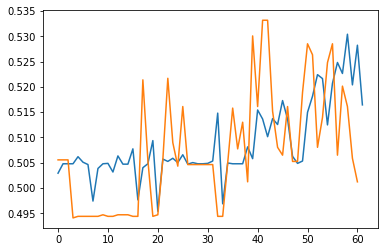

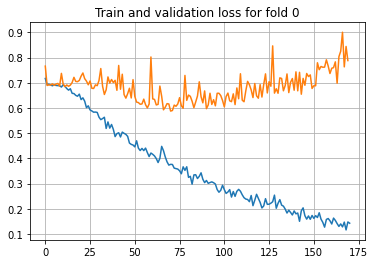

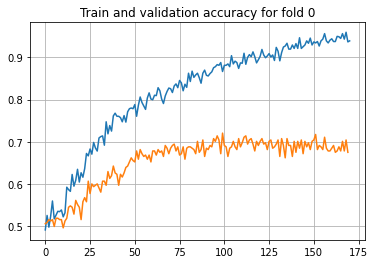

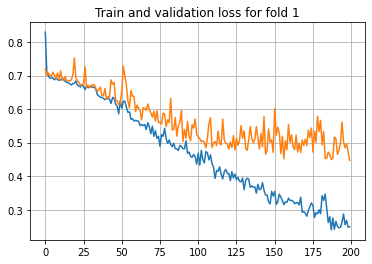

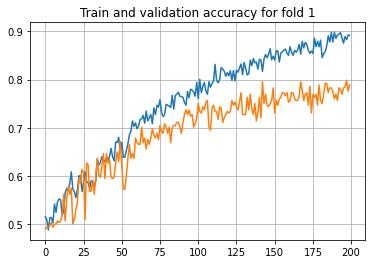

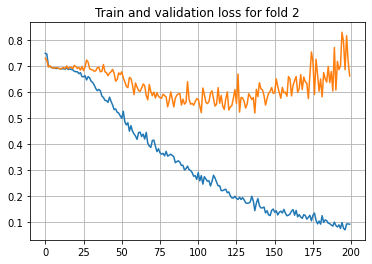

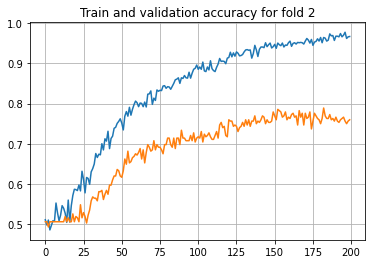

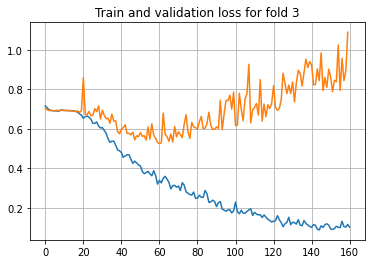

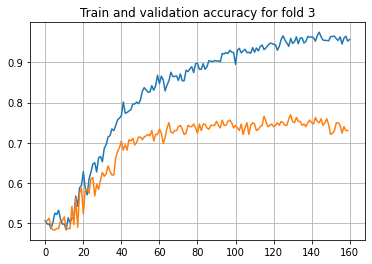

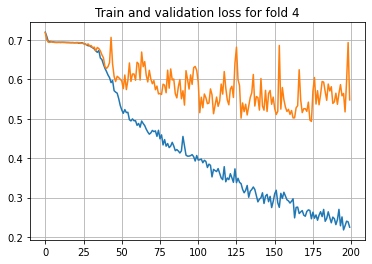

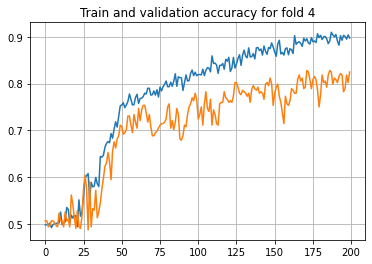

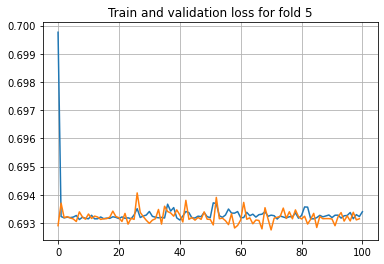

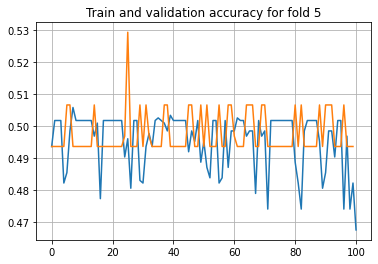

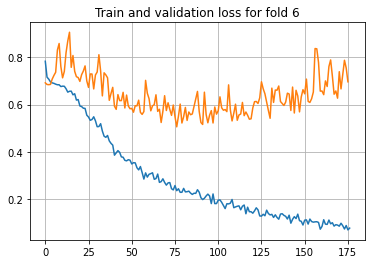

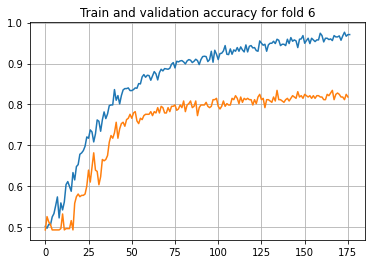

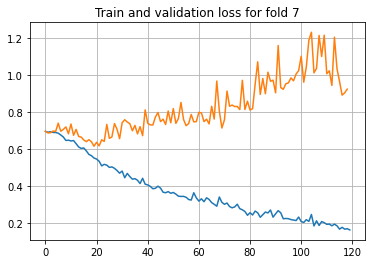

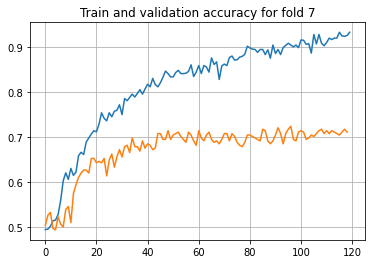

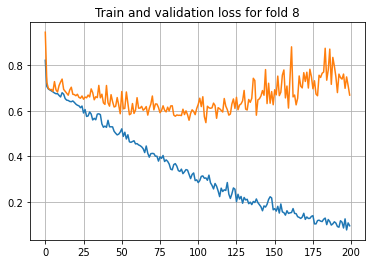

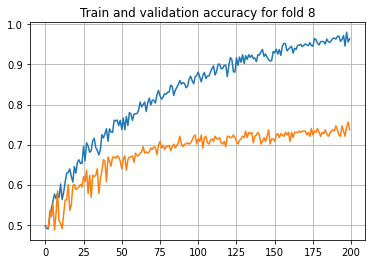

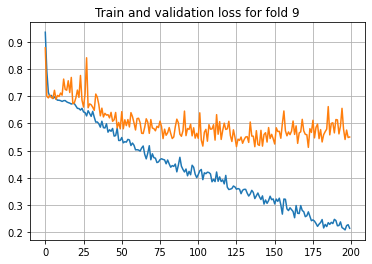

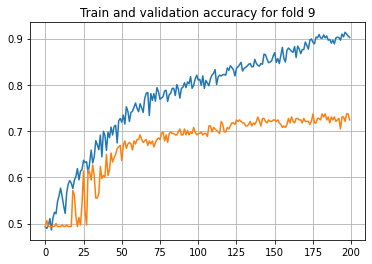

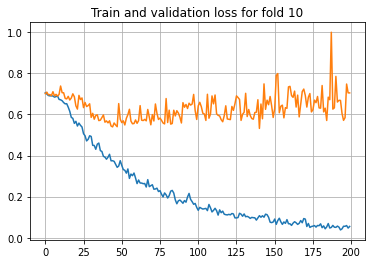

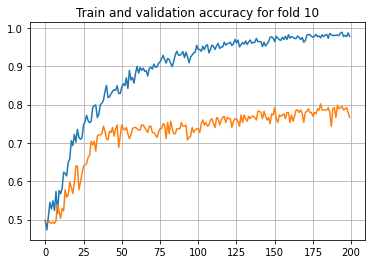

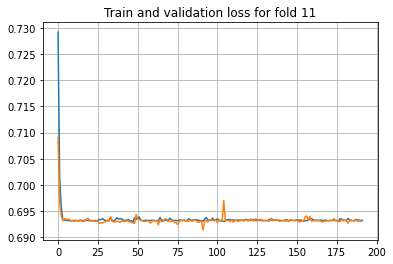

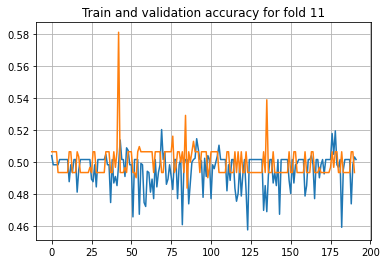

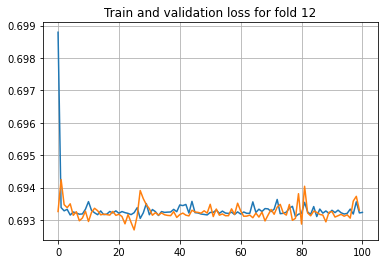

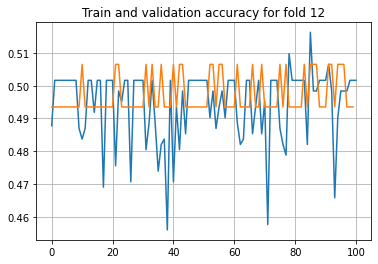

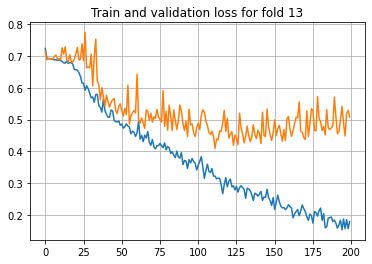

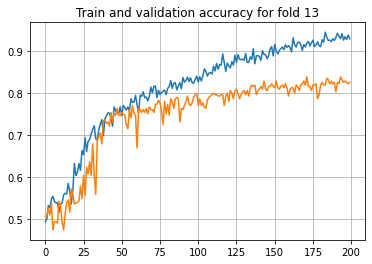

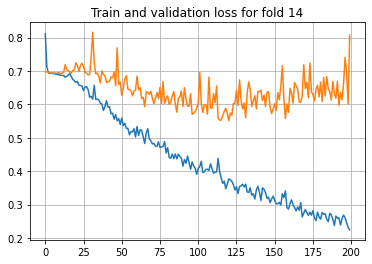

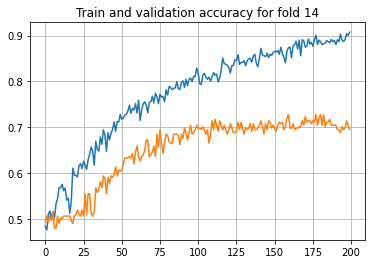

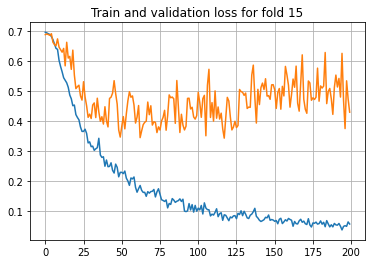

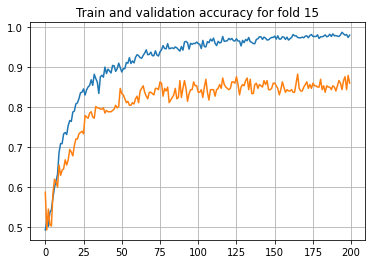

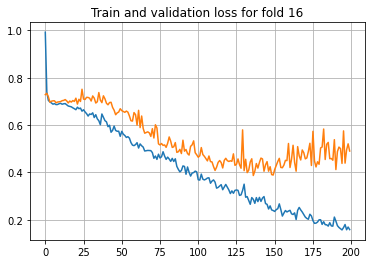

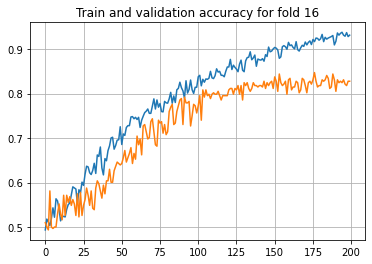

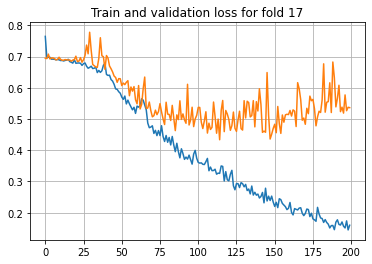

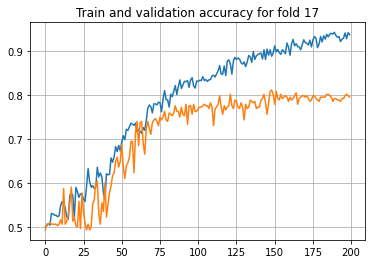

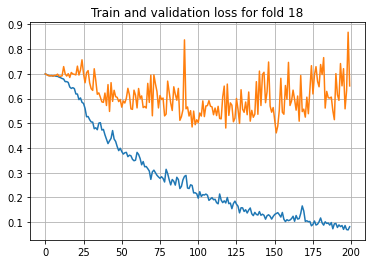

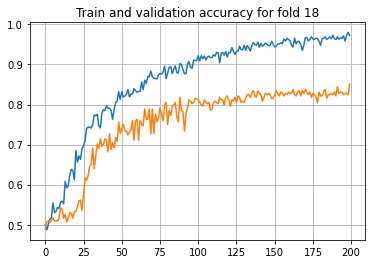

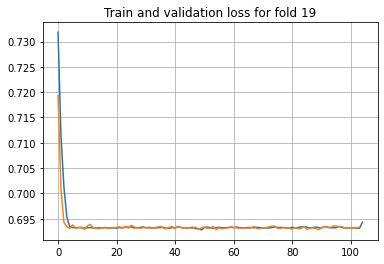

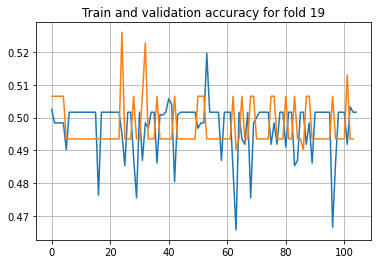

In [ ]:
# @title Definición main {form-width:"25%"}

if(pre_train):
  print("pre train")
  wrapper_pre_train(root_dir, save_dir, datatype, t_start, t_end, fs, float_point, Classes, Conditions,
                  batch_size_pre, val_len, window_len, window_step, scl, SEED, eu_aligment, DEVICE, sub, plotting)
  
wrapper_fine_tuning(root_dir, save_dir, datatype, sub, t_start, t_end, fs, float_point, Classes,
                   Conditions, test_len, val_len, window_len, window_step, scl, eu_aligment, DEVICE, plotting)